In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'release'))

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Closed Loop implemented as Neural ODE

## Models of myosin dynamics

D_t m_ij = (-0.209 + 0.194 c) m_ij + (1.431 + -1.253 c) m_ij Tr(m_ij) + (0.463 + 0.358 c) m_ij Tr(E) + (0.095 + -0.075 c) Static_DV Tr(m_ij)

## Fly closed loop

{'beta': 0.0001,
 'epochs': 500,
 'hidden_size': 128,
 'in_channels': 4,
 'input': ['sqh'],
 'lr': 0.0001,
 'lstm_layers': 2,
 'mode': 'embryo',
 'num_latent': 64,
 'out_channels': 2,
 'output': 'vel',
 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 64]]}
Calibrating flow model to movie intensity
Initializing
Using torchdiffeq solver


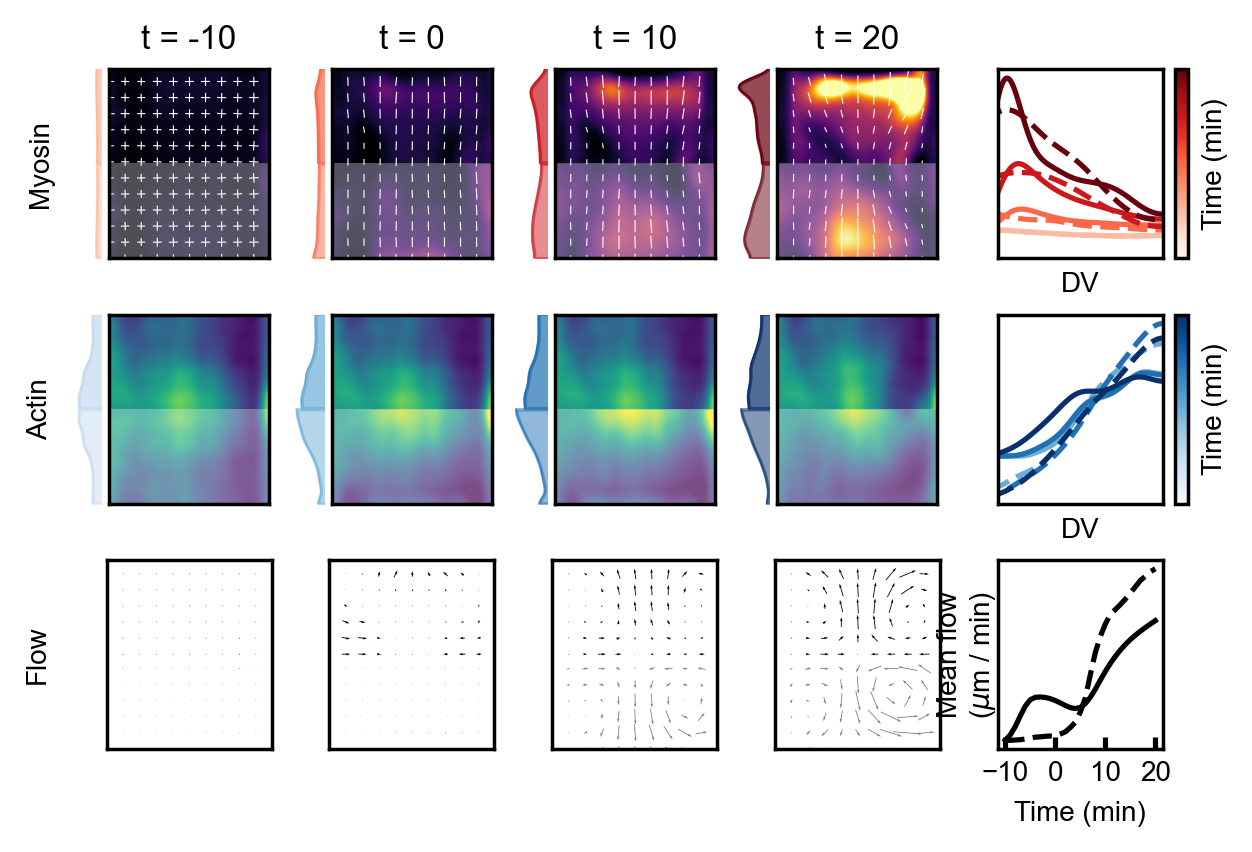

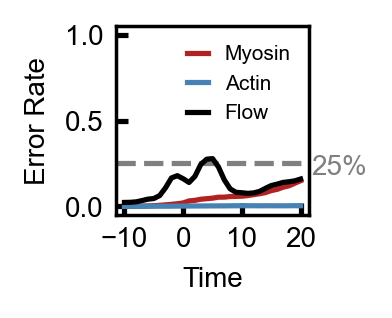

In [13]:
import torch
from pprint import pprint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE
from utils.decomposition.decomposition_model import LeftRightSymmetrize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../tb_logs/November2023/ForecastingVAE_sqh_beta=0.0001_split=embryo') #Works well with sigma = 5
pprint(info['hparams'])

vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_fitting_with_actin.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
    s0 = LeftRightSymmetrize().fit_transform(s0)
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)

fig1, fig2 = comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Actin', s, s0),
    ('Flow', v, v0),
    dt=10)